In an interesting string of events, we've discovered a neural network on numeric features only was the best model. We trained all models with a `comment_text` + numeric feature set since SVC (the predicted best model) performed best with this. Only after experimenting with just numerics in neural network did we realize that it had a marginally higher accuracy with indication of no overfitting. 

However, in terms of the best model for toxicity detection accuracy, random forest ensemble method takes the prize. It does have a lower overall accuracy. Here's the use of the test.csv on the random forest model:

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import sys
scripts_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, scripts_directory)
from scripts import data_cleaning

## Import test set:


In [2]:
train_df = pd.read_csv("../data/train.csv")
df = pd.read_csv("../data/test.csv")

train_df = data_cleaning.clean_data(train_df)
df = data_cleaning.clean_data(df)

## Test on best model: Comment and Numeric Random Forest Ensemble Method

In [3]:
train_df["comment_text"] = train_df["comment_text"].fillna("").astype(str)
df["comment_text"] = df["comment_text"].fillna("").astype(str)

In [4]:
X_train = train_df.drop("rating_rejected", axis=1)
y_train = train_df["rating_rejected"]

X_test = df.drop("rating_rejected", axis=1)
y_test = df["rating_rejected"]

In [5]:
text_col = "comment_text"

cols = [
    c for c in train_df.columns
    if c not in [text_col, "rating_rejected"]
]

In [6]:
preprocess_rf = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            min_df=5,
            max_features=5000
        ), text_col),
        ("num", "passthrough", cols),
    ]
)

best_rf = Pipeline([
    ("preprocess", preprocess_rf),
    ("rf", RandomForestClassifier(
        n_estimators=200,          # best_params['rf__n_estimators']
        max_depth=50,              # best_params['rf__max_depth']
        min_samples_split=2,       # best_params['rf__min_samples_split']
        min_samples_leaf=1,        # best_params['rf__min_samples_leaf']
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

In [7]:
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

In [8]:
print("Testing accuracy (RF tuned):", accuracy_score(y_test, y_test_pred))
print("\Testing classification report (RF tuned):\n")
print(classification_report(y_test, y_test_pred))

Testing accuracy (RF tuned): 0.8200494292575083
\Testing classification report (RF tuned):

              precision    recall  f1-score   support

           0       0.97      0.83      0.90    372673
           1       0.22      0.67      0.33     26281

    accuracy                           0.82    398954
   macro avg       0.60      0.75      0.61    398954
weighted avg       0.92      0.82      0.86    398954



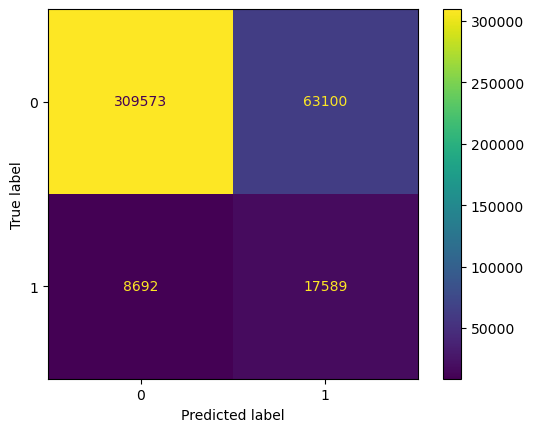

In [9]:
# confusion matrix for best RF ensemble model:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()